# Agriculture-Vision-task

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
!cp '/content/drive/MyDrive/Vison-for-Agriculture-project/vision-for-agriculture.zip' '/content' # move to content then unzip
%cd '/content'
!unzip 'vision-for-agriculture.zip'

In [1]:
import sys
import os
sys.path.append('/content/Agriculture-Vision')
os.chdir('/content/drive/MyDrive/Vison-for-Agriculture-project/Term_project_py')

In [2]:
import numpy as np
import torch
from torch import nn
from torch import functional as F
from torch import optim
from torch.utils.data import dataset, DataLoader, sampler, Subset
import matplotlib.pyplot as plt
from data_utils import *
from layer_utils import *
from Solver import *
import time

%load_ext autoreload
%autoreload 2
plt.rcParams['figure.figsize'] = (12.0, 8.0)

In [3]:
dtype = torch.float64
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device('cpu')
print(device)
print(torch.cuda.get_device_properties(0))

cuda
_CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


In [4]:
train_path = '//content//Agriculture-Vision//train'
val_path = '//content//Agriculture-Vision//val'
train_dataset = Dataset_agriculture(train_path)
val_dataset = Dataset_agriculture(val_path)
small_loader = DataLoader(train_dataset, batch_size=4, sampler=sampler.SubsetRandomSampler(range(5000, 5005)), num_workers=4)
small_val_loader_abab = DataLoader(Subset(train_dataset, range(5000, 5008)), batch_size=4)

val_loader = DataLoader(val_dataset, batch_size=2, sampler=sampler.RandomSampler(range(0, len(val_dataset)), num_samples=20, replacement=True), num_workers=4)
full_loader = DataLoader(train_dataset, batch_size=2, num_workers=4)

In [ ]:
tic = time.time()
means, stds = compute_(small_loader)
toc = time.time()
print(toc-tic)

# tic = time.time()
# aaaa = []
# for all_data in small_loader:
#     train_data, _, _ = concencate_data(all_data)
#     aaaa.append(train_data)
# aaaa = torch.cat(aaaa, dim=0)
# test_mean = np.mean(aaaa.numpy(), axis=(0, 1, 2))
# test_std = np.std(aaaa.numpy(), axis=(0, 1, 2))
# toc = time.time()
# print(toc-tic)

means = tensor([[[[116.1301, 118.6523, 121.8633, 108.1013]]]])
stds = tensor([[[[45.3765, 42.2304, 41.7526, 44.9108]]]])

In [6]:
class U_Net(nn.Module):
    def __init__(self, input_channel, output_classes, bilinear=False):
        super().__init__() # when use nn.Module to build new module，must use nn.Module.__init__()
        factor = 2 if bilinear else 1
        self.doubleconv = DoubleConv(input_channel, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024 // factor)

        self.up4 = Up(1024, 512 // factor, bilinear)
        self.up3 = Up(512, 256 // factor, bilinear)
        self.up2 = Up(256, 128 // factor, bilinear)
        self.up1 = Up(128, 64, bilinear)
        self.output = OutConv(64, output_classes)

    def forward(self, X):
        X1 = self.doubleconv(X)
        X2 = self.down1(X1)
        X3 = self.down2(X2)
        X4 = self.down3(X3)
        X = self.down4(X4)

        X = self.up4(X, X4)
        X = self.up3(X, X3)
        X = self.up2(X, X2)
        X = self.up1(X, X1)
        out = self.output(X)
        return out

class Double_Unet(nn.Module):
  def __init__(self, input_channel, medium_channel, output_classes):
    super().__init__()
    self.first_U = U_Net(input_channel, medium_channel, bilinear=True)
    self.second_U = U_Net(medium_channel, output_classes)
  
  def forward(self, X):
    feature_pic = self.first_U(X)
    out = self.second_U(feature_pic)
    scores = torch.transpose(out, 1, 3)
    return scores

*****start to train!*****
Epochs--> 1 iterations--> 6451
Epoch------(0 / 1)-------
Iteration(50 / 6451)-->loss:0.80752
Iteration(100 / 6451)-->loss:0.78423


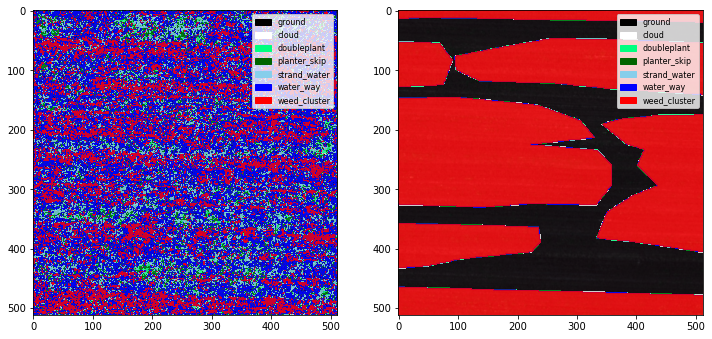

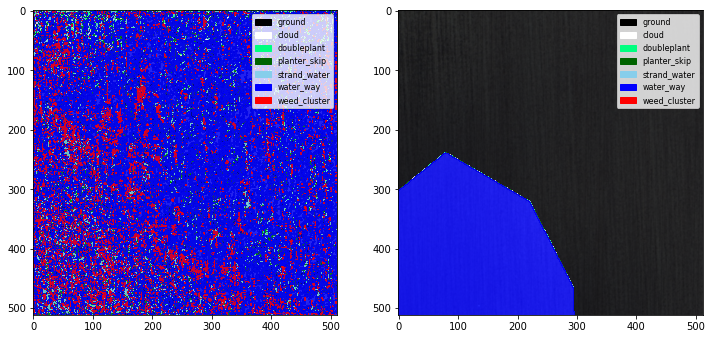

MIOU for each: ground:11.834667902151779% cloud:1.445404168073316% doubleplant:0.7143517133166789% planter_skip:0.0% strand_water:0.09002563103982321% water_way:2.0638549894154723% weed_cluster:9.048562746804842% 
Labl for each: ground:73.64974975585939% cloud:3.44503402709961% doubleplant:0.8036804199218751% planter_skip:0.0% strand_water:0.47325134277343756% water_way:2.4433517456054688% weed_cluster:19.184932708740234% 
Mean MIOU: 4.199477858466985 %
Now best mean_mIOU is: 4.199477858466985
Iteration(150 / 6451)-->loss:0.83034
Iteration(200 / 6451)-->loss:0.81636


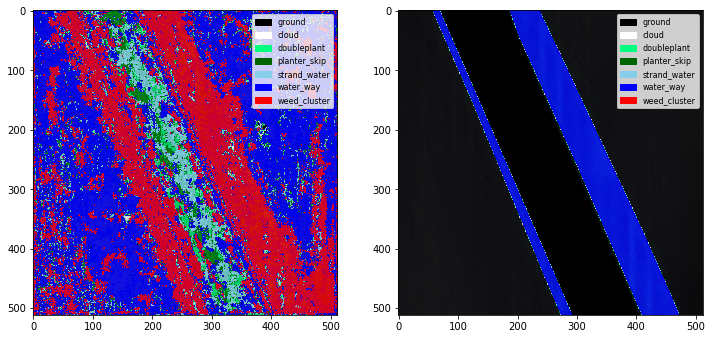

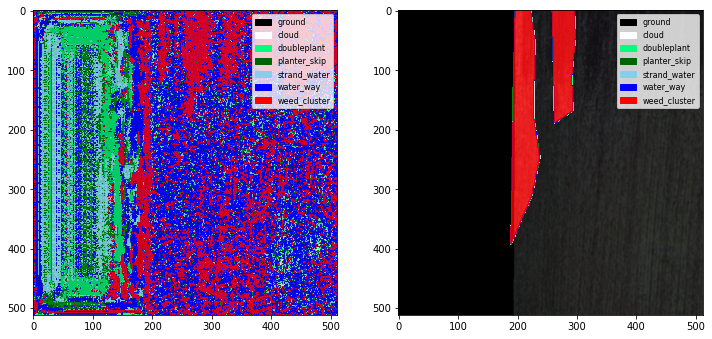

MIOU for each: ground:8.881953774724058% cloud:0.0% doubleplant:0.0% planter_skip:0.0% strand_water:1.2725000774529343% water_way:0.9826471081620101% weed_cluster:20.56100486492245% 
Labl for each: ground:81.7013168334961% cloud:0.0% doubleplant:0.0% planter_skip:0.0% strand_water:0.4933547973632813% water_way:1.9056892395019533% weed_cluster:15.899639129638674% 
Mean MIOU: 7.924526456315363 %
Now best mean_mIOU is: 7.924526456315363
Iteration(250 / 6451)-->loss:1.03824
Iteration(300 / 6451)-->loss:0.85901


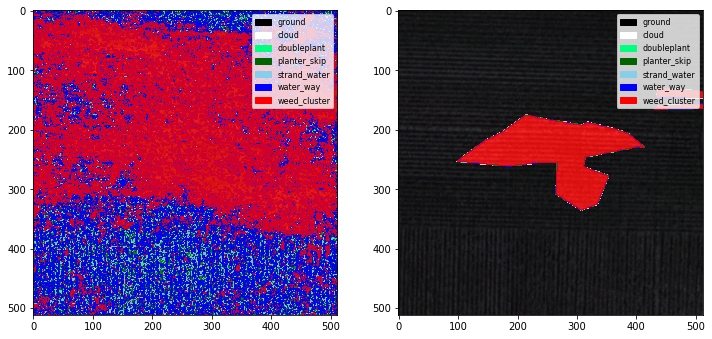

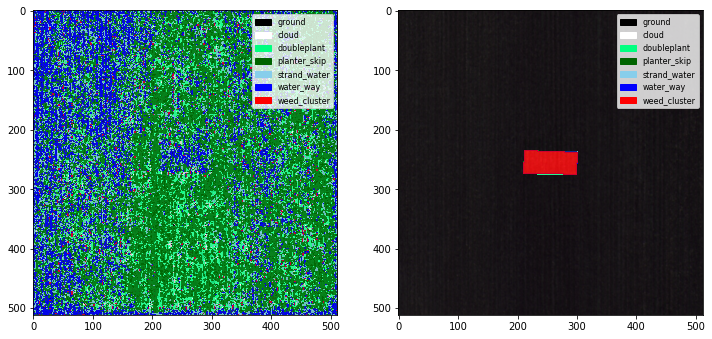

MIOU for each: ground:19.28410242269979% cloud:2.104236794407043% doubleplant:0.08870526094666034% planter_skip:0.5743913359273183% strand_water:0.0% water_way:0.3402939665731558% weed_cluster:19.46145003880305% 
Labl for each: ground:69.32445526123048% cloud:4.648571014404297% doubleplant:0.064544677734375% planter_skip:0.4474830627441406% strand_water:0.0% water_way:0.8377838134765626% weed_cluster:24.677162170410156% 
Mean MIOU: 6.975529969892836 %
Iteration(350 / 6451)-->loss:0.87099
Iteration(400 / 6451)-->loss:0.73990


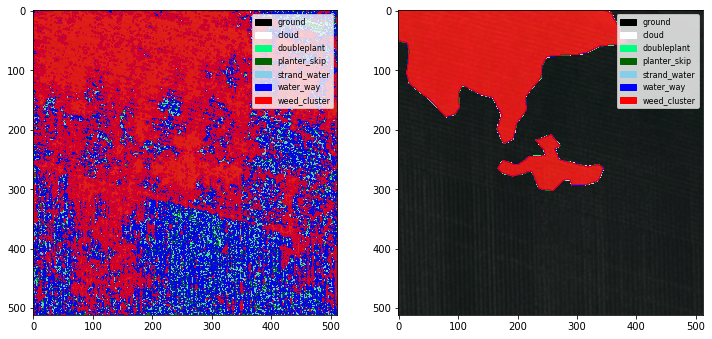

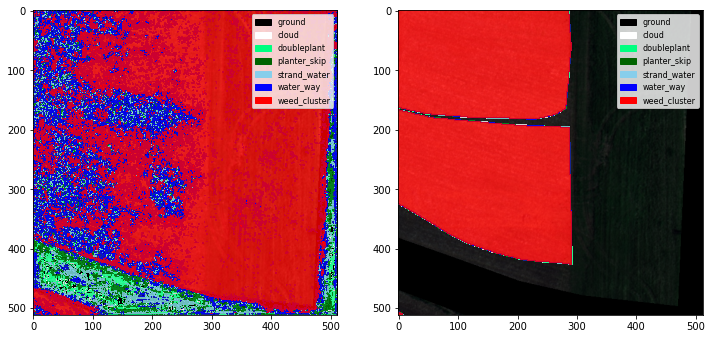

MIOU for each: ground:8.410496418039571% cloud:0.0% doubleplant:0.0% planter_skip:0.0% strand_water:1.815665092948556% water_way:0.36272622043698427% weed_cluster:23.391716530191403% 
Labl for each: ground:75.36966323852539% cloud:0.0% doubleplant:0.0% planter_skip:0.0% strand_water:4.748306274414063% water_way:0.543670654296875% weed_cluster:19.409160614013672% 
Mean MIOU: 8.495151065404128 %
Now best mean_mIOU is: 8.495151065404128
Iteration(450 / 6451)-->loss:0.65662
Iteration(500 / 6451)-->loss:0.73139


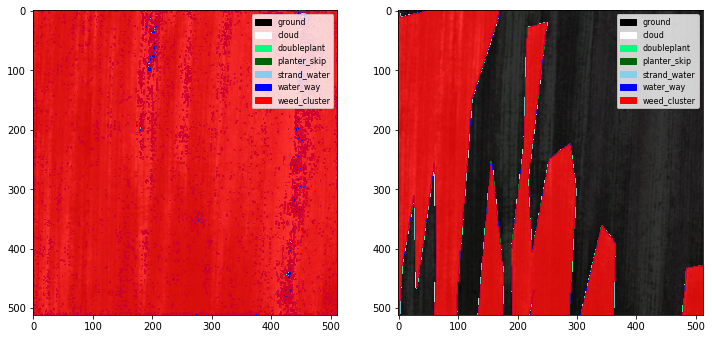

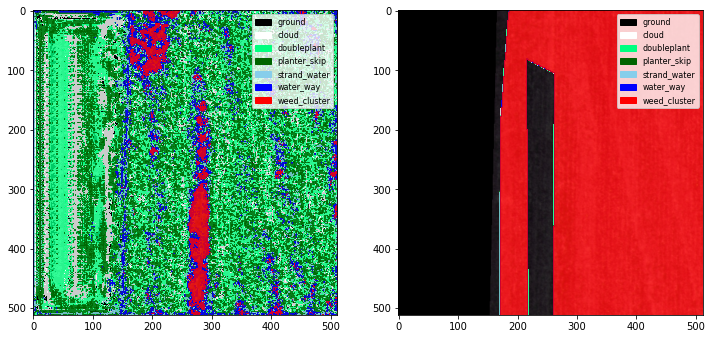

MIOU for each: ground:14.613010923056704% cloud:0.0% doubleplant:0.0052985616253522615% planter_skip:0.0% strand_water:0.0% water_way:1.1927684209514595% weed_cluster:15.951250627579935% 
Labl for each: ground:80.9140396118164% cloud:0.0% doubleplant:0.8345222473144531% planter_skip:0.0% strand_water:0.0% water_way:0.6485176086425782% weed_cluster:17.602920532226562% 
Mean MIOU: 7.940582133303362 %
Checkpoint:500, Save!!
Sucessful Save
Iteration(550 / 6451)-->loss:0.74915
Iteration(600 / 6451)-->loss:0.92649


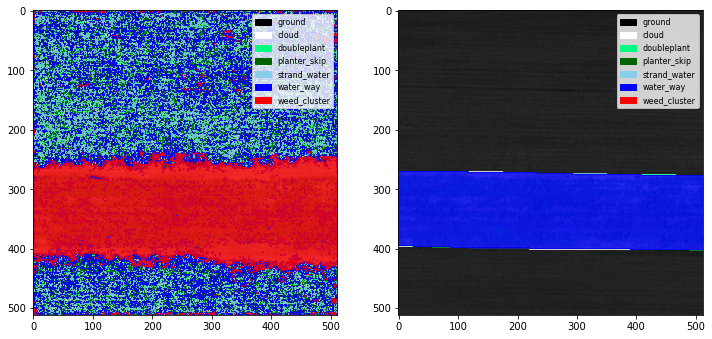

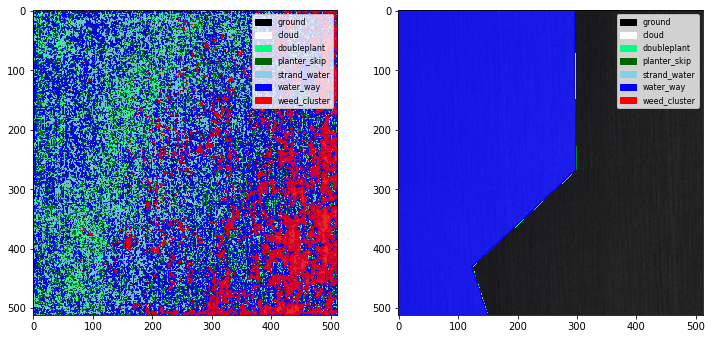

MIOU for each: ground:19.831879633228546% cloud:2.06414888190678% doubleplant:0.547363018746282% planter_skip:0.0% strand_water:0.0% water_way:2.948227691441191% weed_cluster:34.61329852581155% 
Labl for each: ground:74.35983657836914% cloud:2.3890113830566406% doubleplant:0.5237770080566407% planter_skip:0.0% strand_water:0.0% water_way:3.4029388427734375% weed_cluster:19.324436187744144% 
Mean MIOU: 12.00098355022687 %
Now best mean_mIOU is: 12.00098355022687
Iteration(650 / 6451)-->loss:0.72365
Iteration(700 / 6451)-->loss:0.66370


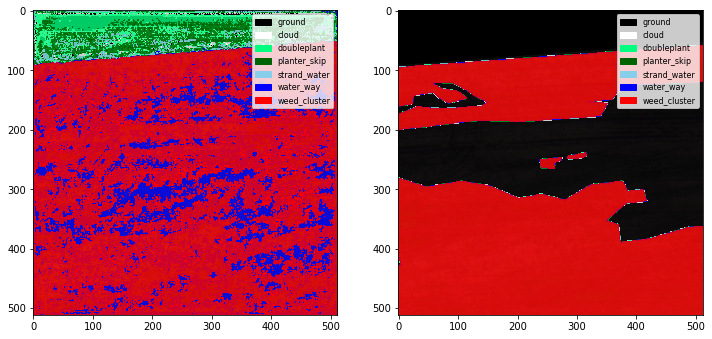

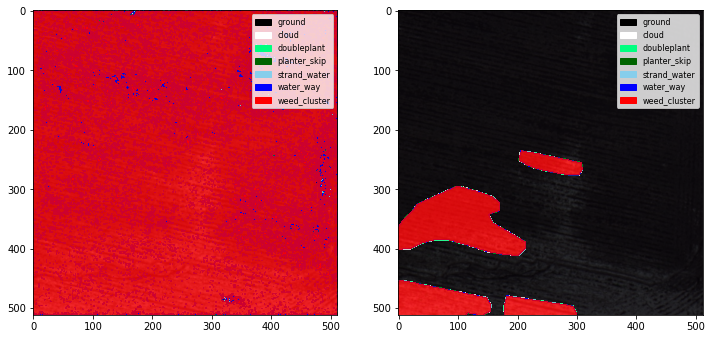

MIOU for each: ground:16.33125331240987% cloud:2.215832703649549% doubleplant:0.0% planter_skip:0.0% strand_water:0.9101933601528623% water_way:0.0% weed_cluster:22.83782475377907% 
Labl for each: ground:79.96902465820312% cloud:1.2127494812011719% doubleplant:0.09916305541992188% planter_skip:0.0% strand_water:0.50018310546875% water_way:0.0% weed_cluster:18.21887969970703% 
Mean MIOU: 8.459020825998271 %


In [ ]:
learning_rate = 2e-4
model = Double_Unet(4, 4, 7)
model = model.to(device=device, dtype=dtype)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True) #训练两次再weight_decay
solver = Solver(model, optimizer, dataloader=full_loader, val_loader=val_loader, batch_time=50, epochs=1, print_every=100)
solver.train()

In [ ]:
classes = ['ground', 'cloud', 'doubleplant', 'planter_skip', 'strand_water', 'water_way', 'weed_cluster']
plt.figure(0, figsize=(10, 10))
plt.subplot(2,1,1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.grid()

plt.subplot(2, 1, 2)
abab = solver.val_acc
train_acc = np.vstack(solver.val_acc)
plt.plot(train_acc, '-o')
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.legend(classes, loc='best')
plt.grid()

In [ ]:
# Solver(model, optimizer, dataloader=full_loader, val_loader=val_loader, batch_time=5, epochs=1, print_every=20) 
# Continue training Part
learning_rate = 5e-4
optimizer = optim.Adam(solver.model.parameters(), lr=learning_rate)
solver.batch_time = 5
solver.dataloader = full_loader
solver.val_loader = val_loader
solver.print_every = 20 
solver.train()

In [ ]:
#Inference
for pic in small_loader:
  picdate, masks = concencate_data(pic, means, stds, preprocess=True, test=True)
  plot_test_data = picdate * stds + means
  test_pic = picdate * masks
  preds = solver.predition(test_pic)
  plot_picture_contour(plot_test_data, masks, preds)

#Save

In [ ]:
save_path = '/content/drive/MyDrive/Vison-for-Agriculture-project/Term_project_py/model_8_9.pth'
torch.save(solver, save_path)


In [ ]:
load_path = '/content/drive/MyDrive/Vison-for-Agriculture-project/Term_project_py/model_8_8.pth'
solver = torch.load(load_path)

# Overfit

In [ ]:
learning_rate = [1e-3, 5e-3, 1e-2, 5e-2]
optimize = ['SGD', 'Adam']
weights = [torch.tensor([1e-3, 1, 1, 1, 1, 1, 1], device=device), torch.tensor([1e-4, 1, 1, 1, 1, 1, 1], device=device)]
results = {}
for lr in learning_rate:
  for optimize_str in optimize:
    for weight in weights:
      print('Now is:', lr, optimize_str, weight)
      model = U_Net(4, 7)
      model = model.to(device=device, dtype=dtype)
      if optimize_str == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
      else: optmizer = optim.Adam(model.parameters(), lr=lr)
      solver = Solver(model, optimizer, dataloader=small_val_loader_abab, val_loader=small_val_loader_abab, batch_time=2, 
                      epochs=10, print_every=2)
      solver.train()
      results[(lr, optimize_str, weight)] = (solver.loss_history, solver.val_acc)

In [ ]:
learning_rate = 5e-3
model = Double_Unet(4, 7, 3)
model = model.to(device=device, dtype=dtype)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True) #训练两次再weight_decay
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
solver = Solver(model, optimizer, dataloader=small_val_loader_abab, val_loader=small_val_loader_abab, loss_name='BCEDICE', batch_time=1, epochs=30, print_every=1)
solver.train()